## Experimentation ground

### Imports

In [32]:
import pickle
from random import shuffle
import random
from baselineModels.GraphRNN.data import Graph_to_sequence
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import networkx as nx
import torch
from torch.utils.data import Dataset

### Training loss visualisation

In [2]:


def vis_train_loss_epoch(folder_name, title):
    train_data_file = open(folder_name, 'rb')
    db = pickle.load(train_data_file)
    epoch = list(range(len(db['train_step'])))
    plt.plot(epoch, db['train_loss'])
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Train_loss")
    plt.show()

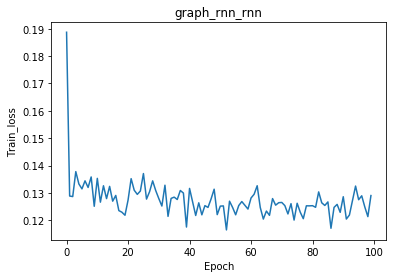

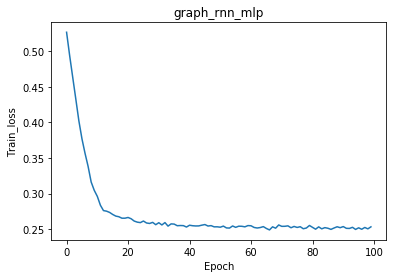

In [22]:
folder_rnn = 'exp/GraphRNN/RNN_erdos_2021-Jun-21-22-28-25_18312/train_stats.p'
folder_mlp = 'exp/GraphRNN/RNN_erdos_2021-Jun-21-20-50-55_16260/train_stats.p'
folder_mlp_1000='exp/GraphRNN/RNN_erdos_2021-Jun-30-13-19-51_9376/train_stats.p'
vis_train_loss_epoch(folder_rnn, 'graph_rnn_rnn')
vis_train_loss_epoch(folder_mlp, 'graph_rnn_mlp')

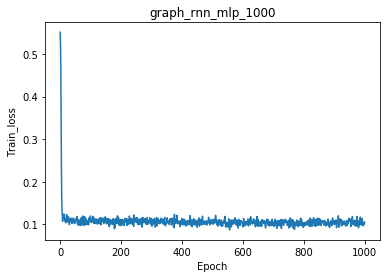

In [5]:
folder_mlp_1000='exp/GraphRNN/RNN_erdos_2021-Jun-30-13-19-51_9376/train_stats.p'
vis_train_loss_epoch(folder_mlp_1000, 'graph_rnn_mlp_1000')

### Experiment on the influence of synthethic dataset

In [24]:
def calc_max_prev_node(G, iter=20000, topk=10):
    max_prev_node = []
    for i in range(iter):
        if i % (iter / 5) == 0:
            print('iter {} times'.format(i))
        adj_idx = np.random.randint(len(G))
        adj_copy = G[adj_idx].copy()
        # print('Graph size', adj_copy.shape[0])
        x_idx = np.random.permutation(adj_copy.shape[0])
        adj_copy = adj_copy[np.ix_(x_idx, x_idx)]
        adj_copy_matrix = np.asmatrix(adj_copy)
        G = nx.from_numpy_matrix(adj_copy_matrix)
        # then do bfs in the permuted G
        start_idx = np.random.randint(adj_copy.shape[0])
        x_idx = np.array(bfs_seq(G, start_idx))
        adj_copy = adj_copy[np.ix_(x_idx, x_idx)]
        # encode adj
        adj_encoded = encode_adj_flexible(adj_copy.copy())
        if adj_encoded == []:
            continue
        max_encoded_len = max([len(adj_encoded[i]) for i in range(len(adj_encoded))])
        max_prev_node.append(max_encoded_len)
    max_prev_node = sorted(max_prev_node)[-1 * topk:]
    return max_prev_node

def encode_adj_flexible(adj):
    '''
    return a flexible length of output
    note that here there is no loss when encoding/decoding an adj matrix
    :param adj: adj matrix
    :return:
    '''
    # pick up lower tri
    adj = np.tril(adj, k=-1)
    n = adj.shape[0]
    adj = adj[1:n, 0:n - 1]

    adj_output = []
    input_start = 0
    for i in range(adj.shape[0]):
        input_end = i + 1
        adj_slice = adj[i, input_start:input_end]
        adj_output.append(adj_slice)
        non_zero = np.nonzero(adj_slice)[0]
        input_start = input_end - len(adj_slice) + np.amin(non_zero)

    return adj_output

def bfs_seq(G, start_id):
    '''
    get a bfs node sequence
    :param G:
    :param start_id:
    :return:
    '''
    dictionary = dict(nx.bfs_successors(G, start_id))
    start = [start_id]
    output = [start_id]
    while len(start) > 0:
        next = []
        while len(start) > 0:
            current = start.pop(0)
            neighbor = dictionary.get(current)
            if neighbor is not None:
                #### a wrong example, should not permute here!
                # shuffle(neighbor)
                next = next + neighbor
        output = output + next
        start = next
    return output

In [34]:
max_prev_nodes=[]
p_parameters=np.arange(0.1,1,0.05)
random.seed(123)

for p in p_parameters:
    graphs=[]
    for i in range(100, 200):
        graphs.append(nx.erdos_renyi_graph(i, p))
    shuffle(graphs)
    dataset = Graph_to_sequence(graphs)
    m=dataset.max_prev_node
    max_prev_nodes.append(m)


calculating max previous node, total iteration: 20000
iter 0 times
iter 4000 times
iter 8000 times
iter 12000 times
iter 16000 times
max previous node: 170
calculating max previous node, total iteration: 20000
iter 0 times
iter 4000 times
iter 8000 times
iter 12000 times
iter 16000 times
max previous node: 178
calculating max previous node, total iteration: 20000
iter 0 times
iter 4000 times
iter 8000 times
iter 12000 times
iter 16000 times
max previous node: 183
calculating max previous node, total iteration: 20000
iter 0 times
iter 4000 times
iter 8000 times
iter 12000 times
iter 16000 times
max previous node: 187
calculating max previous node, total iteration: 20000
iter 0 times
iter 4000 times
iter 8000 times
iter 12000 times
iter 16000 times
max previous node: 189
calculating max previous node, total iteration: 20000
iter 0 times
iter 4000 times
iter 8000 times
iter 12000 times
iter 16000 times
max previous node: 191
calculating max previous node, total iteration: 20000
iter 0 tim

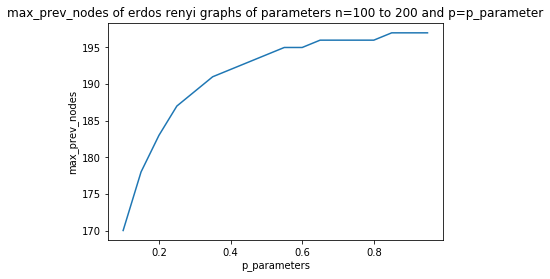

In [35]:
plt.plot(p_parameters,max_prev_nodes)
plt.title("max_prev_nodes of erdos renyi graphs of parameters n=100 to 200 and p=p_parameter")
plt.xlabel("p_parameters")
plt.ylabel("max_prev_nodes")
plt.show()